<a href="https://colab.research.google.com/github/yeonkkk/AIFFEL-Project/blob/main/Exploration16/project/%5BE_16%5DSRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ✨사전 학습

[E-16. 흐린 사진을 선명하게](https://github.com/yeonkkk/AIFFEL-Project/tree/main/Exploration16/project#e-16-%ED%9D%90%EB%A6%B0-%EC%82%AC%EC%A7%84%EC%9D%84-%EC%84%A0%EB%AA%85%ED%95%98%EA%B2%8C)

# 프로젝트 1. 직접 고른 이미지로 SRGAN 실험하기

bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습  


## 프로젝트 1-1. 고해상도 이미지 활용하기
- (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

- 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄임  

- 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성

- 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘림

- 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화


<br>

- ❗ **결과 설명** 
  - 3개의 이미지를 전체적으로 비교해보았을 때 차이점을 구분하기는 어려웠다.
  - 이미지의 일부분을 크롭하여 비교해보니 차이가 확연하게 들어나는 것을 확인할 수 있었다.
  - Bicubic: 이미지가 매우 흐릿하며 저해상도 이미지인 것이 확실하게 느껴진다.
  - SRGAN: Bicubic 이미지에 비해 매우 선명하나, 원본 사진에 비교하면 매우 거친 느낌이 든다. 선명도는 높아졌으나 과한 느낌이 있다.

In [2]:
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model, layers, Sequential, losses, metrics, optimizers
import os
from tensorflow.python.keras import applications
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [11]:
hr_image = cv2.imread('/content/drive/MyDrive/AIffel/ex16/winter.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

In [12]:
hr_image.shape

(1278, 1920, 3)

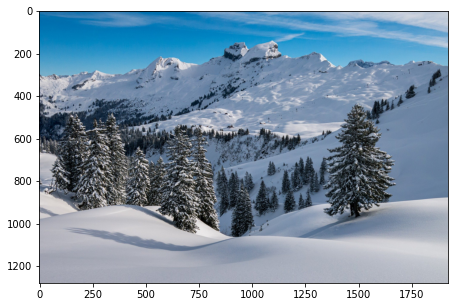

In [18]:
plt.figure(figsize=(10,5))
plt.imshow(hr_image)

In [37]:
bicubic_image = cv2.resize(
    hr_image, 
    dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4),
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

bicubic_hr = cv2.resize(
    bicubic_image, 
    dsize=(bicubic_image.shape[1]*4, bicubic_image.shape[0]*4),
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

In [38]:
print(bicubic_image.shape)
print(bicubic_hr.shape)

(319, 480, 3)
(1276, 1920, 3)


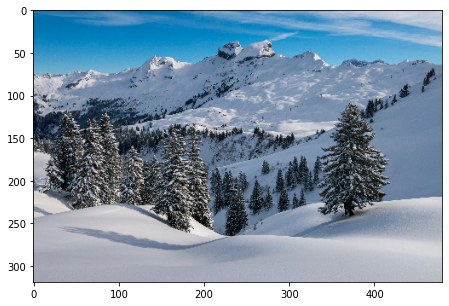

In [35]:
plt.figure(figsize=(10,5))
plt.imshow(bicubic_image)

### SRGAN 적용하기

In [36]:
model_file = '/content/drive/MyDrive/AIffel/ex16/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [39]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [40]:
srgan_hr = apply_srgan(bicubic_image)

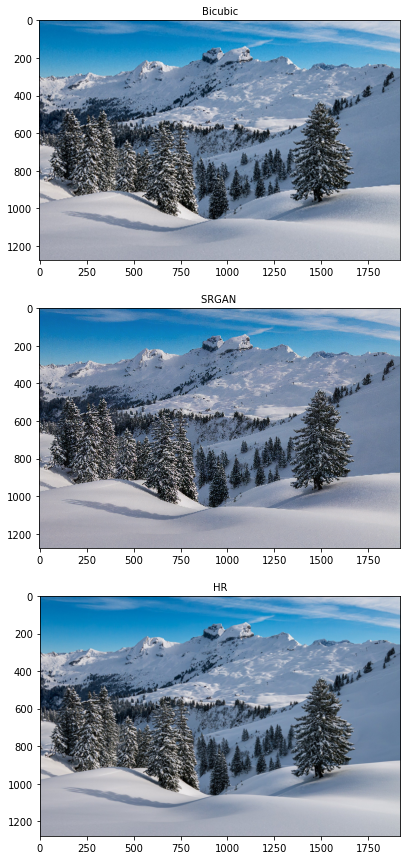

In [107]:
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN ", "HR"]

plt.figure(figsize=(20,15))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(3,1,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=10)

In [108]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=300, y=300):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

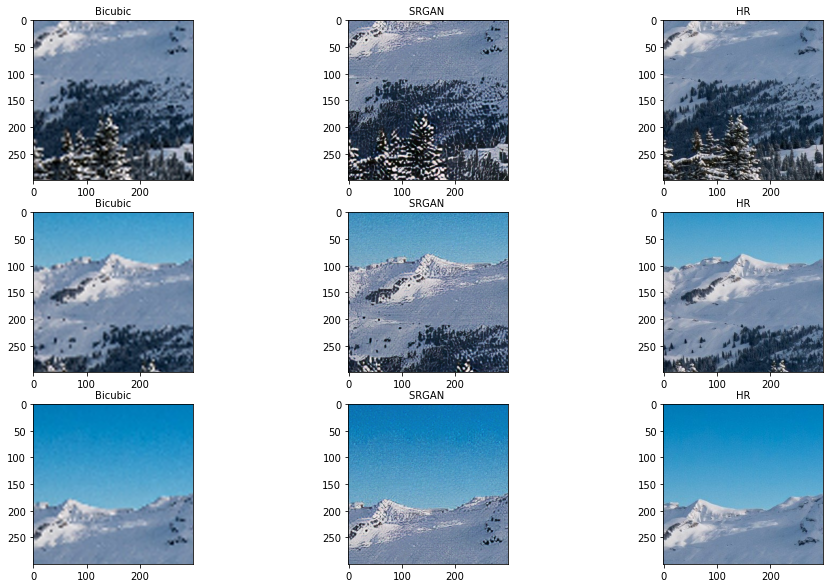

In [109]:
# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(300,200)] *3 + [(200,120)] *3 + [(100,200)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=10)

---
## 프로젝트 1-2. 저해상도 이미지 활용하기


- (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장
- 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성
- 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘림
- 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화

<br>

- ❗ **결과 설명** 
  - 저해상도 사진을 찾기 어려워 그냥 직접 찍었던 사진을 이용하였다.
  - 2개의 이미지를 전체적으로 비교해보았을 때 차이점을 구분하기는 어려웠다.
  - 이미지의 일부분을 크롭하여 비교해보니 차이가 확연하게 들어나는 것을 확인할 수 있었다.
  - Bicubic: 이미지가 매우 흐릿하며, 해상도가 낮은 것이 느껴진다.
  - SRGAN: Bicubic 이미지에 비해 좀 더 선명한 것을 확인할 수 있다. 괄목할 만한 결과는 없었지만 경계가 비교적 뚜렷한 것은 확인할 수 있다.

In [54]:
lr_image = cv2.imread('/content/drive/MyDrive/AIffel/ex16/test.jpg')
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)

In [55]:
lr_image.shape

(966, 773, 3)

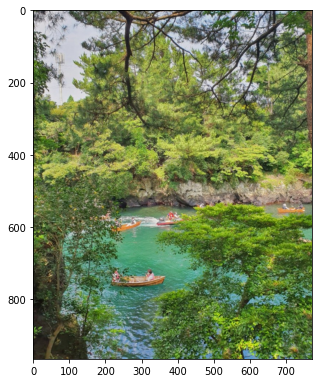

In [57]:
plt.figure(figsize=(5,10))
plt.imshow(lr_image)

In [58]:
srgan_lr = apply_srgan(lr_image)

In [68]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_lr = cv2.resize(
    lr_image, 
    dsize=(lr_image.shape[1]*4, lr_image.shape[0]*4), 
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

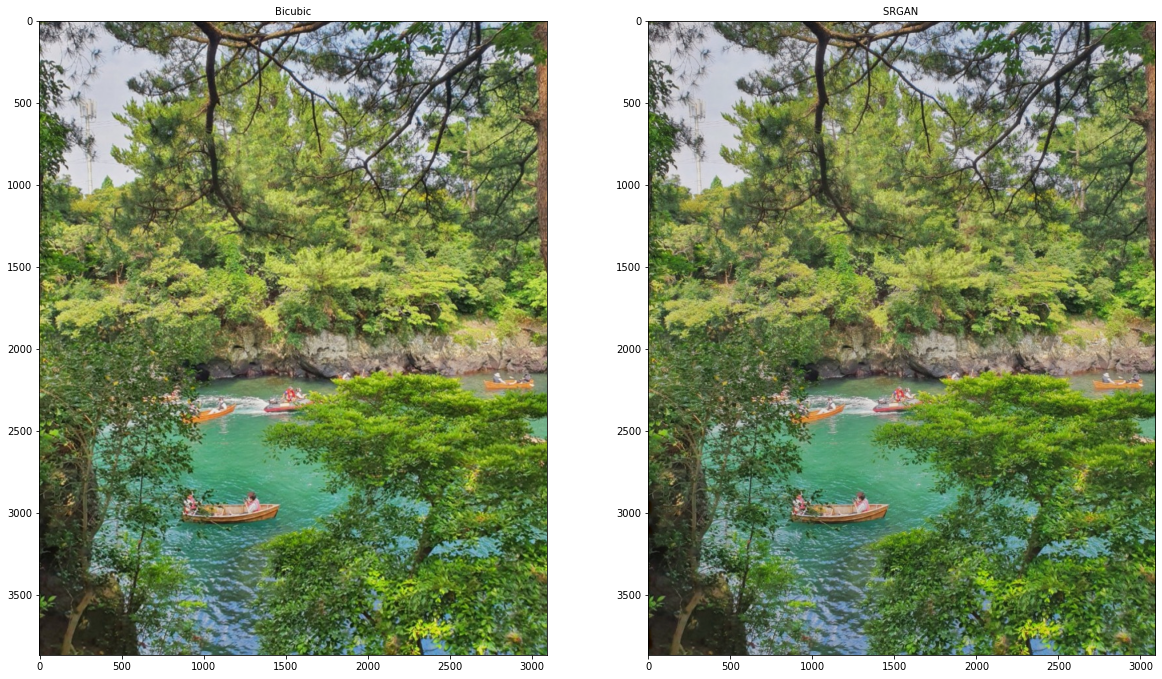

In [78]:
images2 = [bicubic_lr, srgan_lr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(20,15))
for i, (image, title) in enumerate(zip(images2, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=10)

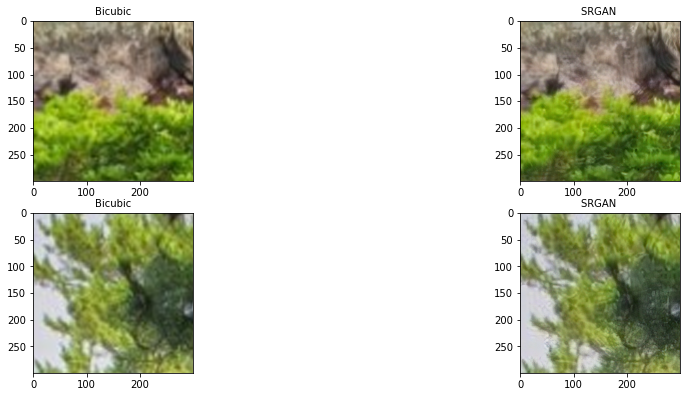

In [93]:
# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(2000,2000)] *2 + [(500,500)] *2

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images2*2, left_tops, titles*2)):
    plt.subplot(3,2,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=10)

---
# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보기  


## 1. gif 파일 불러오기

In [94]:
!pip install imageio

In [95]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("/content/drive/MyDrive/AIffel/ex16/city_night_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


---
## 2. 프레임별 Super Resolution 진행하기


Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘리기  
Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣기  

In [96]:
frames_sr_bicubic = []

for i in frames:
    a = cv2.resize(i, dsize=(i.shape[1]*4, i.shape[0]*4),interpolation=cv2.INTER_CUBIC)
    frames_sr_bicubic.append(a)

In [97]:
frames_sr_srgan = []
for frame in frames:
    b = apply_srgan(frame)
    frames_sr_srgan.append(b)

---
## 3. 프레임을 합쳐 gif 만들기

In [101]:
import imageio

imageio.mimsave("/content/drive/MyDrive/AIffel/ex16/bicubic.gif", frames_sr_bicubic)
imageio.mimsave("/content/drive/MyDrive/AIffel/ex16/srgan.gif", frames_sr_srgan)

---
## 4. Jupyter notebook에 gif 표시하기

In [105]:
from IPython.display import Image as show_gif

**원본.gif**

![city_night_lr](https://user-images.githubusercontent.com/88660886/143484421-8bbd00da-32c9-4028-bfd4-142b4f8f1f2e.gif)


**bicubic.gif**

![bicubic (2)](https://user-images.githubusercontent.com/88660886/143483993-d7f40859-4921-4867-9e98-560bb20f761a.gif)


**srgan.gif**


![srgan](https://user-images.githubusercontent.com/88660886/143484590-468ed83d-5420-466a-b4f3-e3c08b4e18af.gif)


----
# 회고

## 루브릭

|평가문항|상세기준|
|:---|:---|
|1. SRGAN을 이용해 고해상도의 이미지를 생성하였다.|SRGAN을 통해 생성된 이미지를 제출하였다.|
|2. 다양한 해상도의 이미지에 대해 시각화를 통해 원본, SRGAN생성본, interpolation생성본을 비교분석하였다.|이미지의 특성과 super resolution 방법을 관련지어 생성 결과를 체계적으로 분석하였다.|
|3. 저해상도 gif 동영상을 고해상도 동영상으로 성공적으로 변환하였다.|저해상도 원본 gif와 생성된 고해상도 gif의 해상도 차이가 시각적으로 확인 가능하다.|


## 결과 평가 및 회고

마지막 gif 결과물들을 보면, bicubic이미지에 비해 SRGAN을 활용한 것이 확실히 선명한 것을 확인할 수 있다.  

원본과 비교하였을 때는 엄청나게 나아진 느낌은 아니지만 그에 비슷한 정도의 선명도를 보이는 것 같다는 생각이 든다.  

이번 프로젝트는 다른 프로젝트보다 즐겁게 할 수 있었던 것 같다.  
적용한 것에 대한 결과가 눈에 잘 보이고, 비교하는 과정도 신기하고 매우 흥미로웠다.  

다른 프로젝트는 성과를 내고 제출하는 것에 급급했는데 본 프로젝트는 진행하면서 이걸 어떻게 활용할 수 있을지, 어떤 서비스에 녹여낼 수 있는지 등을 생각해볼 수 있었던 힐링 프로젝트였다.  

